In [160]:
from scipy.integrate import solve_ivp
from scipy.stats import gamma as gamma_dist
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

In [161]:
import sys
sys.path.append("../code")
import model
import plotting

## Parameters

In [162]:
y0 = {
    'S': 276618.,
    'V': 599864.,
    'W':  97500.,
    'E':    390.,
    'EB':    39.,
    'I':    974.,
    'IB':    97.,
    'ICU':   18.,
    'R':  24500.,
    'UC':650000.,
    'WC':  5000.,
}

params = {
    'y0': list(y0.values()),
    'Rt_base': 3.0,
    'Rt_free': 4.0,
    'eta': 0.8,
    'kappa': 0.95,
    'sigma': 0.5,
    'gamma': 0.1,
    'gamma_ICU': 0.13,
    'delta': 0.0019,
    'rho': 0.25,
    'omega_v_b': 1./(6*30),
    'omega_n_b': 1./(12*30),
    'chi_0': 0.1,
    'chi_1': 0.2,
    'alpha_w': 0.008,
    'alpha_u': 0.01,
    'alpha_R': 0.008,
    'e_R': 0.,
    'e_u': 0.,
    'e_w': 0.,
    'Phi_0': 0.0025,
    'phi_0': 0.0025,
    'u_base': 0.5,
    'mu': 0.267,
    'd_0': 8*30.,
    'd_mu': 0.,
    'a_Rt': 4.,
    'a_vac': 14.,
    'gamma_cutoff': 30.,
    'tau_vac1': 6*7.,
    'tau_vac2': 2*7.,
    't_max': 360.,
    'step_size': 0.1,
}

## Model

In [163]:
params_m1 = params.copy()
params_m2 = params.copy()
params_m3 = params.copy()

params_m1["Rt_base"] = 2
params_m2["Rt_base"] = 3
params_m3["Rt_base"] = 4

m1 = model.Model(**params_m1)
m2 = model.Model(**params_m2)
m3 = model.Model(**params_m3)

In [164]:
times, data = m1.run()
times, data = m2.run()
times, data = m3.run()

In [165]:
plotting.overview(m1, path="./figures/scenario1.pdf", silent=True)
plotting.overview(m2, path="./figures/scenario2.pdf", silent=True)
plotting.overview(m3, path="./figures/scenario3.pdf", silent=True)

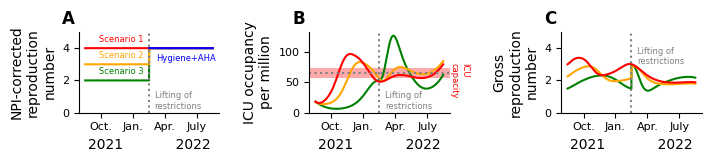

In [170]:
#mpl.rcParams['font.sans-serif'] = "Arial"
fig = plt.figure(figsize=(7, 1.5), constrained_layout=True)
grid = fig.add_gridspec(ncols=3, nrows=1, wspace=0.1)

ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1], sharex=ax1)
ax3 = fig.add_subplot(grid[2], sharex=ax1, sharey=ax1)

c = {
    'low':'green', 'mid':'orange', 'high':'red', 'free':'blue',
    'line':'gray', 'ICUcap':'#FFAAAA',
}
tmp = [c['low'],c['mid'],c['high']]
for i,m in enumerate([m1,m2,m3]):
    ax1.plot(m.times, list(map(m.R_0, m.times)), color=tmp[i])
    ax2.plot(m.times, m.chopped_data()[:,7], color=tmp[i])
    ax3.plot(m.times, list(map(m.Rt, m.times)), color=tmp[i])

ax1.plot(m1.times[1800:], list(map(m1.R_0, m1.times[1800:])), color=c['free'])

for ax in [ax1,ax2,ax3]:
    ax.axvline(180, ls=':', color=c['line'])
    ax.set_xlabel('2021            2022')

ax1.set_ylim(0,5)
ax2.set_ylim(0,None)

ax1.set_ylabel("NPI-corrected\nreproduction\nnumber")
ax2.set_ylabel("ICU occupancy\nper million")
ax3.set_ylabel("Gross\nreproduction\nnumber")

ax1.text(40,2.0+0.4,'Scenario 3', size=6, color=c['low'])
ax1.text(40,3.0+0.4,'Scenario 2', size=6, color=c['mid'])
ax1.text(40,4.0+0.4,'Scenario 1', size=6, color=c['high'])
ax1.text(200,3.2,'Hygiene+AHA', size=6, color=c['free'])

ax1.text(0.54,0.05,'Lifting of\nrestrictions', size=6, color=c['line'], transform=ax1.transAxes)
ax2.text(0.54,0.05,'Lifting of\nrestrictions', size=6, color=c['line'], transform=ax2.transAxes)
ax3.text(0.54,0.60,'Lifting of\nrestrictions', size=6, color=c['line'], transform=ax3.transAxes)

ax1.text(-.12,1.1,'A', size=12, weight='bold', color='black', transform=ax1.transAxes)
ax2.text(-.12,1.1,'B', size=12, weight='bold', color='black', transform=ax2.transAxes)
ax3.text(-.12,1.1,'C', size=12, weight='bold', color='black', transform=ax3.transAxes)

ax2.axhline(65, ls=':', color=c['line'])
ax2.axhspan(65-8,65+8, facecolor=c['ICUcap'], edgecolor=None)
ax2.text(1,0.2,'ICU\ncapacity', size=6, color='red', rotation=-90, transform=ax2.transAxes)

# Jan, Feb, Mar, Apr, May, June, July, Aug, Sept, Oct, Nov, Dec
xticks = np.arange(45,360,90) # 15th of months
plt.xticks(xticks,['Oct.','Jan.','Apr.','July'])

plt.show()
fig.savefig("./figures/paper_fig1.pdf")

In [141]:
xticks

array([ 45, 135, 225])

## Gamma distributions

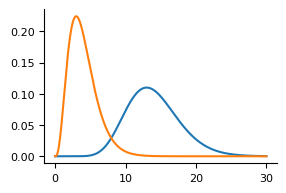

In [9]:
fig = plt.figure(figsize=(3, 2))
x = np.arange(0,30,0.01)
plt.plot(x,gamma_dist.pdf(x,14))
plt.plot(x,gamma_dist.pdf(x,4))
plt.show()

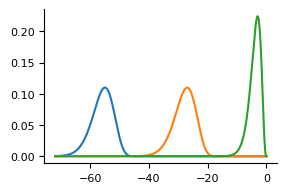

In [10]:
fig = plt.figure(figsize=(3, 2))
x = np.arange(-params["gamma_cutoff"]-params["tau_vac1"],0,0.01)
plt.plot(x,gamma_dist.pdf(-x-params["tau_vac1"],14))
plt.plot(x,gamma_dist.pdf(-x-params["tau_vac2"],14))
plt.plot(x,gamma_dist.pdf(-x,4))
plt.show()

In [156]:
mpl.rcParams.update(mpl.rcParamsDefault)

#mpl.rcParams['font.sans-serif'] = "Arial"
#mpl.rcParams['font.family'] = "sans-serif"

#mpl.rcParams['axes.linewidth'] = 0.3
mpl.rcParams["axes.labelcolor"] = "black"
mpl.rcParams["axes.edgecolor"] = "black"
mpl.rcParams["xtick.color"] = "black"
mpl.rcParams["ytick.color"] = "black"

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

mpl.rcParams["xtick.labelsize"] = 8
mpl.rcParams["ytick.labelsize"] = 8
mpl.rcParams["axes.labelsize"] = 10
mpl.rcParams["axes.titlesize"]= 10
mpl.rcParams["legend.fontsize"] = 8
mpl.rcParams["legend.title_fontsize"] = 10

colors_paul = ["#233954", "#ea5e48", "#1e7d72", "#f49546", "#e8bf58", # dark
               "#5886be", "#f3a093", "#53d8c9", "#f2da9c", "#f9c192"] # light